In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import torch
import torch.nn as nn
import yaml
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

In [2]:
class RNN(nn.Module):
    def __init__(
            self, n_in, n_out, n_hid, device,
            alpha_time_scale=0.25, jij_std=0.045,
            activation='tanh',
            sigma_neu=0.05,
            use_bias=True,
            ffnn=False,
    ):
        super(RNN, self).__init__()
        self.n_in = n_in
        self.n_hid = n_hid
        self.n_out = n_out
        self.w_in = nn.Linear(n_in, n_hid, bias=use_bias)
        self.w_hh = nn.Linear(n_hid, n_hid, bias=use_bias)
        nn.init.uniform_(self.w_hh.weight, -jij_std, jij_std)
        self.w_out = nn.Linear(n_hid, n_out, bias=use_bias)

        self.activation = activation
        self.sigma_neu = sigma_neu

        self.device = device
        self.ffnn = ffnn

        self.alpha = torch.ones(self.n_hid) * alpha_time_scale
        self.alpha = self.alpha.to(self.device)

    def change_alpha(self, new_alpha_time_scale):
        self.alpha = torch.ones(self.n_hid) * new_alpha_time_scale
        self.alpha = self.alpha.to(self.device)

    def make_neural_noise(self, hidden, alpha):
        return torch.randn_like(hidden).to(self.device) * self.sigma_neu * torch.sqrt(alpha)

    def forward(self, input_signal, hidden, length):
        num_batch = input_signal.size(0)
        hidden_list = torch.zeros(length, num_batch, self.n_hid).type_as(input_signal.data)
        output_list = torch.zeros(length, num_batch, self.n_out).type_as(input_signal.data)

        input_signal = input_signal.permute(1, 0, 2)

        for t in range(length):
            if self.activation == 'tanh':
                if self.ffnn:
                    tmp_hidden = self.w_in(input_signal[t])
                    hidden = torch.tanh(tmp_hidden)
                else:
                    activated = torch.tanh(hidden)
                    tmp_hidden = self.w_in(input_signal[t]) + self.w_hh(activated)
                    neural_noise = self.make_neural_noise(hidden, self.alpha)
                    hidden = (1 - self.alpha) * hidden + self.alpha * tmp_hidden + neural_noise
            elif self.activation == 'relu':
                if self.ffnn:
                    tmp_hidden = self.w_in(input_signal[t])
                    hidden = torch.nn.functional.relu(tmp_hidden)
                else:
                    tmp_hidden = self.w_in(input_signal[t]) + self.w_hh(hidden)
                    tmp_hidden = torch.nn.functional.relu(tmp_hidden)
                    neural_noise = self.make_neural_noise(hidden, self.alpha)
                    hidden = (1 - self.alpha) * hidden + self.alpha * tmp_hidden + neural_noise
            else:
                raise ValueError

            output = self.w_out(hidden)
            output = torch.clamp(output, min=-20, max=20)
            hidden_list[t] = hidden
            output_list[t] = output

        hidden_list = hidden_list.permute(1, 0, 2)
        output_list = output_list.permute(1, 0, 2)

        return hidden_list, output_list, hidden

In [3]:
def make_signal_cc_task(num_sample, time_length, mu_min, mu_max, uncertainty,fix_input=False):
    input_signals = np.zeros([num_sample, time_length, 200])
    phi = np.linspace(-20, 20, 100)
    sigma_sq = 5
    mu_post_list = []
    sigma_post_list = []
    for i in range(num_sample):
        signal1_input = np.zeros([time_length, 100])
        signal2_input = np.zeros([time_length, 100])
        mu = np.random.rand() * (mu_max - mu_min) + mu_min
        g_1, g_2 = np.random.rand(2) + 0.25
        signal1_base = g_1 * np.exp(-(mu - phi) ** 2 / (2.0 * sigma_sq))
        signal2_base = g_2 * np.exp(-(mu - phi) ** 2 / (2.0 * sigma_sq))
        for t in range(time_length):
            signal1_input[t] = np.random.poisson(signal1_base)
        for t in range(time_length):
            signal2_input[t] = np.random.poisson(signal2_base)
        if fix_input:
            tmp1 = np.random.poisson(signal1_base)
            tmp2 = np.random.poisson(signal2_base)
            for t in range(time_length):
                signal1_input[t] = tmp1
                signal2_input[t] = tmp2
            
        # target
        sigma_1 = np.sqrt(1 / g_1) * uncertainty
        sigma_2 = np.sqrt(1 / g_2) * uncertainty
        mu_posterior = ((sigma_1 ** 2) * mu +
                        (sigma_2 ** 2) * mu) / (sigma_1 ** 2 + sigma_2 ** 2)
        g_3 = g_1 + g_2
        sigma_posterior = np.sqrt(1 / g_3) * uncertainty
        
        input_signals[i] = np.concatenate((signal1_input, signal2_input), axis=1)
        
        mu_post_list.append(mu_posterior)
        sigma_post_list.append(sigma_posterior)

    return input_signals, mu_post_list, sigma_post_list

In [4]:
config_path = '../probabilistic_inference/cfg/sample.yml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)

In [5]:
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=200, n_out=1, n_hid=cfg['MODEL']['SIZE'], device=device,
    alpha_time_scale=cfg['MODEL']['ALPHA'], 
    activation=cfg['MODEL']['ACTIVATION'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    use_bias=cfg['MODEL']['USE_BIAS'],
    ffnn=False,
).to(device)

model_path = f'../trained_model/cue_combination_sampling/{model_name}/epoch_200.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

model_name:  sample


RNN(
  (w_in): Linear(in_features=200, out_features=300, bias=True)
  (w_hh): Linear(in_features=300, out_features=300, bias=True)
  (w_out): Linear(in_features=300, out_features=1, bias=True)
)

In [19]:
sample_num = 100

outputs_np = np.zeros(sample_num)
input_signal, mu_post_list, sigma_post_list = make_signal_cc_task(
    sample_num, 
    time_length=cfg['DATALOADER']['TIME_LENGTH'], 
    mu_min=-15,
    mu_max=15,
    uncertainty=cfg['DATALOADER']['UNCERTAINTY'],
    fix_input=False,
)

In [20]:
hidden_np = np.zeros((sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                                             
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, _ = model(inputs, hidden, cfg['DATALOADER']['TIME_LENGTH'])                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()    

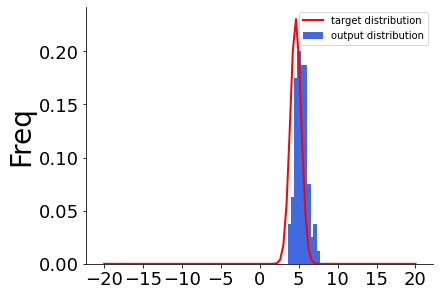

In [21]:
target_sample = np.random.normal(mu_post_list[8], sigma_post_list[8], 100)

fig = plt.figure(constrained_layout=True)
plt.bar(
    np.linspace(-20, 20, 100),
    np.histogram(outputs.detach().numpy()[8, :, 0], bins=100, range=(-20, 20))[0] / 80,
    color='royalblue',
    label='output distribution',
    linewidth=2,
    width=0.5,
)

x = np.linspace(-20, 20, 100)
y = stats.norm.pdf(np.linspace(-20, 20, 100), scale=sigma_post_list[8], loc=mu_post_list[8])
plt.plot(
    x,
    y / np.sum(y),
    color='red',
    label='target distribution',
    linewidth=2,
)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend()

plt.ylabel('Freq', fontsize=28)

plt.show()